# 任务
- 为了吸引观众的注意力，广告视频的长度、音频、文本位置和画面会有与众不同之处。
- 我们将使用人工智能的方法构建一套商用广告识别系统来预测抖音短视频是否为商用广告，通过对Tik Tok平台上视频的时长、声音频谱、视频光谱、文字分布、画面变化等特征，进行特征抽取、特征过滤等方式处理后进行建模，来快速区分出投稿视频中的商业广告。
- 具体包括
    - 了解这份数据
    - 进行必要的数据清洗
    - 自由进行特征生成、特征选择、特征降维等工作
    - 建立合适的预测模型，并进行调参
    - 选用合适的方式进行模型集成，优化模型

# 数据
- 广告数据集包括5次采样、总长度为150小时的抖音视频中提取的视频镜头的标准视听特征，以270 fps的分辨率录制视频，分辨率为720 X 576。将视频数据处理为视频的时长、声音频谱、视频光谱、文字分布和画面变化等特征，以判断其是否为商用广告。最终的数据包含1个标签、230个特征。
- 数据提供了129685份视频的信息，储存在commercial_vedio_data.csv文件中，其中labels为标签。
- 数据集共包230个特征，涵盖视频的时长、声音频谱、视频光谱、文字分布和画面变化等方面。
- 具体描述详见：数据集和变量说明.pdf

## 视觉特征
- 视频镜头长度Length  1
- 每个视频镜头的屏幕文本分布Text    92-122
- 运动分布Move      2-3     18-58
- 帧差异分布Frame    4-5     59-91
- 边缘变化率Edge    4124-4125

## 音频特征
- 短期能量Energe      6-7
- 零交叉率ZCR      8-9
- 光谱质心Centroid      10-11
- 光谱通量Flux      14-15
- 频谱滚降频率Rolloff  12-13
- 基频BasFreq          16-17
- 音频词包MFCC  123-4123

# 一、数据的探索与问题分析
- 导入库
- 导入数据集
- 获得特征和标签
- 重命名标签
- 数据整体描述
- 查看分布

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

# 导入文件依据运行的环境和平台进行必要的更改
data = pd.read_csv("../commercial_vedio_data.csv", index_col=0)

# Rename
data.rename(columns={'1':'Length', '2':'Move_E', '3':'Move_D', '4':'Frame_E', '5':'Frame_D', '6':'Energe_E', '7':'Energe_D', '8':'ZCR_E', '9':'ZCR_D', '10':'Centroid_E', '11':'Centroid_D', '12':'Rolloff_E', '13':'Rolloff_D', '14':'Flux_E', '15':'Flux_D', '16':'BasFreq_E', '17':'BasFreq_D', '4124':'Edge_E', '4125':'Edge_D', 'labels':'Label'}, inplace=True)

# 特征名和标签名
col_name = data.columns[:-2]
label_name = data.columns[-1]

print ('训练集的标签:{}\n'.format(label_name))
print ('训练集的特征:{}\n'.format(col_name))
print ('训练集的形状:{}\n'.format(data.shape))

训练集的标签:Label

训练集的特征:Index(['Length', 'Move_E', 'Move_D', 'Frame_E', 'Frame_D', 'Energe_E',
       'Energe_D', 'ZCR_E', 'ZCR_D', 'Centroid_E',
       ...
       '882', '924', '959', '1002', '1016', '1028', '1048', '1112', '1119',
       'Edge_E'],
      dtype='object', length=229)

训练集的形状:(129685, 231)



In [2]:
# 打印data的前五行数据
data.head()

,Length,Move_E,Move_D,Frame_E,Frame_D,Energe_E,Energe_D,ZCR_E,ZCR_D,Centroid_E,...,959,1002,1016,1028,1048,1112,1119,Edge_E,Edge_D,Label
0,123,1.316440,1.516003,5.605905,5.346760,0.013233,0.010729,0.091743,0.050768,3808.067871,...,0.036017,0.006356,0.008475,NaN,0.002119,NaN,NaN,0.422334,0.663918,1
1,124,0.966079,0.546420,4.046537,3.190973,0.008338,0.011490,0.075504,0.065841,3466.266113,...,0.117647,0.006303,NaN,NaN,0.008403,NaN,NaN,0.332664,0.766184,1
2,109,2.035407,0.571643,9.551406,5.803685,0.015189,0.014294,0.094209,0.044991,3798.196533,...,0.062500,0.004808,NaN,NaN,0.009615,NaN,NaN,0.346674,0.225022,1
3,86,3.206008,0.786326,10.092709,2.693058,0.013962,0.011039,0.092042,0.043756,3761.712402,...,0.046296,0.012346,NaN,NaN,0.012346,0.003086,NaN,0.993323,0.840083,1
4,76,3.135861,0.896346,10.348035,2.651010,0.020914,0.012061,0.108018,0.052617,3784.488037,...,NaN,0.003521,NaN,NaN,0.045775,0.007042,NaN,0.341520,0.710470,1


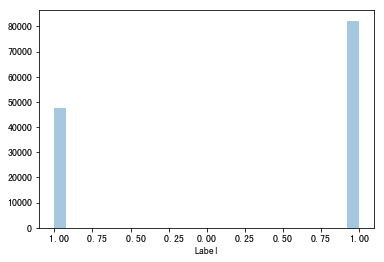

In [3]:
# Label分布的直方图
sns.distplot(data['Label'], kde=False)

In [4]:
# 描述数据中特征的分布
data.describe()

,Length,Move_E,Move_D,Frame_E,Frame_D,Energe_E,Energe_D,ZCR_E,ZCR_D,Centroid_E,...,959,1002,1016,1028,1048,1112,1119,Edge_E,Edge_D,Label
count,129685.000000,129685.000000,129685.000000,129685.000000,129685.000000,129685.000000,129685.000000,129685.000000,129685.000000,129685.000000,...,62719.000000,53351.000000,41920.000000,1860.000000,55528.000000,13108.000000,217.000000,129685.000000,129685.000000,129685.000000
mean,106.400000,2.587003,1.601049,11.918077,8.264462,0.015218,0.009762,0.103230,0.056772,3481.604677,...,0.044993,0.040969,0.055489,0.003688,0.035440,0.006209,0.036149,0.500648,0.500378,0.268165
std,264.814882,2.179930,1.374998,9.068333,6.847135,0.005434,0.003281,0.037289,0.021509,669.086147,...,0.056405,0.049836,0.069591,0.004812,0.043293,0.012654,0.075509,0.288909,0.288068,0.963377
min,25.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000059,0.000059,0.000073,0.000014,0.000007,0.000047,0.000271,0.000032,0.000003,-1.000000
25%,30.000000,0.947497,0.674715,5.380625,3.244237,0.012589,0.008073,0.083190,0.045150,3390.920654,...,0.011161,0.008621,0.009770,0.000836,0.009804,0.001208,0.004464,0.250215,0.251995,-1.000000
50%,49.000000,1.970185,1.343323,9.476908,6.584897,0.015709,0.010057,0.102859,0.054889,3608.322998,...,0.025000,0.023585,0.028226,0.001988,0.022727,0.002687,0.012500,0.501763,0.499753,1.000000
75%,96.000000,3.710244,2.163196,16.568928,11.572393,0.018552,0.012005,0.123875,0.066628,3774.575684,...,0.057143,0.056830,0.076539,0.004556,0.045455,0.006410,0.037500,0.751095,0.749926,1.000000
max,33871.000000,21.679216,37.363274,67.285736,63.396584,0.036905,0.021416,0.394551,0.246353,4005.922607,...,0.812500,0.637500,1.012500,0.050000,0.840909,0.223214,0.512500,0.999973,0.999997,1.000000


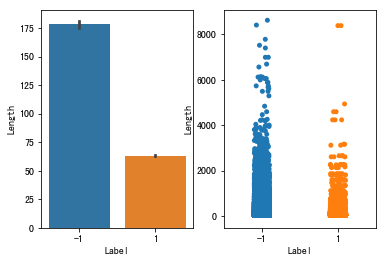

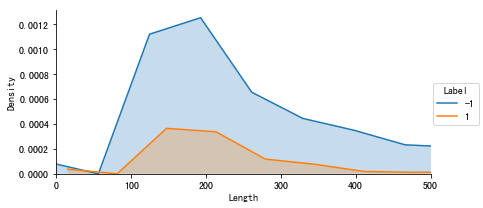

In [5]:
# 时长Length分布和统计
data.drop(data[data['Length'] > 10000].index.tolist(), inplace=True)

fig, axes = plt.subplots(1, 2)
sns.barplot(x='Label', y='Length', data=data, ax=axes[0])
sns.stripplot(x='Label', y='Length', data=data, ax=axes[1], jitter=True)
plt.show()

facet = sns.FacetGrid(data[['Length', 'Label']], hue='Label', aspect=2)
facet.map(sns.kdeplot, "Length", shade=True)
facet.set(xlim=(0, 500))
facet.add_legend()
facet.set_axis_labels("Length", "Density")

# 清洗数据
- 查看、填充缺失值
- 去除重复样本
- 无离散型变量，无需get_dummies

In [6]:
# 缺失值
data.isnull().any()

Length        False
Move_E        False
Move_D        False
Frame_E       False
Frame_D       False
Energe_E      False
Energe_D      False
ZCR_E         False
ZCR_D         False
Centroid_E    False
Centroid_D    False
Rolloff_E     False
Rolloff_D     False
Flux_E        False
Flux_D        False
BasFreq_E     False
BasFreq_D     False
18             True
19             True
20             True
21             True
22             True
23             True
24             True
25             True
26             True
27             True
28             True
29             True
30             True
              ...  
623            True
627            True
634            True
651            True
689            True
694            True
709            True
726            True
762            True
767            True
779            True
785            True
792            True
816            True
840            True
852            True
871            True
877            True
882            True


In [7]:
# 填充缺失值
data = data.fillna(data.mean())

In [8]:
# 重复值
data.drop_duplicates(inplace=True)
data.shape

(111615, 231)

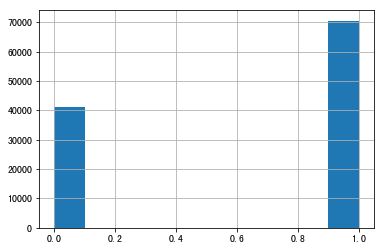

In [9]:
# Label -1 -> 0
data['Label'] = data['Label'].apply(lambda x:0 if x == -1 else x)
data['Label'].hist()

# 特征工程
- 特征过滤
- 特征生成
- 特征分箱

可综合多种方法进行特征工程
- 一是使用某些方法生成新的特征纳入模型进行预测
- 二是通过某些方法进行特征过滤，减少纳入模型的特征数量
- 三是对连续特征进行特征分箱，离散特征进行特征组合。

In [10]:
# 分离特征和标签
X = data.drop(['Label'], axis=1)
Y = data['Label']

# 划分训练集和测试集
from sklearn.model_selection import train_test_split
xtrain, xtest, ytrain, ytest = train_test_split(X, Y, train_size=0.75)

xtrain.shape

(83711, 230)

## 特征选择By随机森林
- 使用随机森林进行特征选择
- 训练集拟合随机森林模型
- 用于获得feature_importances_

In [11]:
from sklearn.ensemble import RandomForestClassifier
rfcModel = RandomForestClassifier()
rfcModel.fit(xtrain, ytrain)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

## 特征重要性排序
- 通过重要性值进行排序画出柱状图
- 通过计算前缀和画出阶梯图

In [12]:
# 将特征的重要性程度进行排序
N_most_important = 25

imp = np.argsort(rfcModel.feature_importances_)[::-1]
imp_slct = imp[:N_most_important]

FeaturesImportances = zip(col_name, map(lambda x:round(x,5), rfcModel.feature_importances_))
FeatureRank = pd.DataFrame(columns=['Feature', 'Imp'], data=sorted(FeaturesImportances, key=lambda x:x[1], reverse=True)[:N_most_important])

In [13]:
# 重新选择X
xtrain_slct = xtrain.iloc[:,imp_slct]
xtest_slct  = xtest.iloc[:,imp_slct]

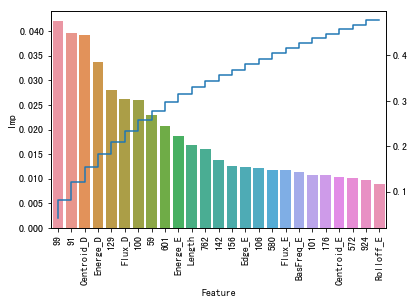

In [14]:
# 特征排序图
ax1 = fig.add_subplot(111)
ax1 = sns.barplot(x='Feature', y='Imp', data=FeatureRank)
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=90)

SumImp = FeatureRank
for i in SumImp.index:
    if (i==0):
        SumImp['Imp'][i] = FeatureRank['Imp'][i]
    else:
        SumImp['Imp'][i] = SumImp['Imp'][i-1] + FeatureRank['Imp'][i]
ax2 = ax1.twinx()
plt.step(x=SumImp['Feature'], y=SumImp['Imp'])


## PCA

> 使用PCA进行特征生成，即与选择出的主成分与原数据合并，能够一定程度上提高预测精准度

- 对训练集使用PCA生成新特征，根据累计贡献率，保留前5个主成分
- 对测试集进行相同的操作，注意测试集上直接使用pca中的transform函数，相同方法处理训练集和测试集

In [15]:
from sklearn.decomposition import PCA
pca = PCA(n_components=N_most_important)
pca.fit(xtrain)
pca.explained_variance_ratio_

array([  6.43408692e-01,   1.92190041e-01,   1.31253657e-01,
         1.94366805e-02,   7.60179565e-03,   5.29987007e-03,
         7.02181587e-04,   7.28384745e-05,   2.36647757e-05,
         6.10954565e-06,   3.62783604e-06,   6.03369069e-07,
         9.68736153e-08,   2.08350806e-08,   2.06471758e-08,
         2.01867494e-08,   1.26466131e-08,   7.44633832e-09,
         5.67050896e-09,   5.42859597e-09,   4.52445675e-09,
         3.68913183e-09,   3.15974972e-09,   2.98863019e-09,
         2.58603015e-09])

In [16]:
# 对训练集使用PCA生成新特征，根据累计贡献率，保留前5个主成分
pca1 = PCA(6)
pc = pd.DataFrame(pca1.fit_transform(xtrain))
pc.index = xtrain.index
xtrain_pca = xtrain.join(pc)

In [17]:
# 对测试集进行相同的操作，注意测试集上直接使用pca中的transform函数
pc = pd.DataFrame(pca1.fit_transform(xtest))
pd.index = xtrain.index
xtest_pca = xtest.join(pc)

## 特征分箱By决策树
- 使用cut_bin和cut_test_bin基于决策树进行分箱
- 重新获得训练集和测试集

In [18]:
#  cut_bin对训练集进行分箱
def cut_bin(df,label,max_depth,p):
    df_bin = df[[label]]
    df_feature = df.drop([label],axis=1)
    dict_bin = {}
    for col in df_feature.columns:
        get_model = DecisionTreeClassifier(max_depth=max_depth,min_samples_leaf=int(p*len(df)))
        get_cut_point = get_model.fit(df[col].values.reshape(-1,1),df[label].values.reshape(-1,1))
        cut_point = get_cut_point.tree_.threshold[get_cut_point.tree_.threshold!=-2]
        
        N_split = np.zeros_like(df[col])
        inter_range = []
        if len(cut_point)==1:
            N_split[np.array(df[col]<cut_point[0])]=1
            N_split[np.array(df[col]>=cut_point[0])]=2
            inter_range=[[1,-100000000,cut_point[0]],[2,cut_point[0],100000000]]
        elif len(cut_point)>1:
            cut_point.sort()
            N_split[np.array(df[col]<cut_point[0])]=1
            inter_range=[[1,-100000000,cut_point[0]]]
            for i in range(len(cut_point)-1):
                N_split[np.array((df[col]>=cut_point[i]) & (df[col]<cut_point[i+1]))]=i+2
                inter_range=inter_range+[[i+2,cut_point[i],cut_point[i+1]]]
            N_split[np.array(df[col]>=cut_point[len(cut_point)-1])]=len(cut_point)+1
            inter_range=inter_range+[[len(cut_point)+1,cut_point[len(cut_point)-1],100000000]]
        else:
            N_split=1
            inter_range=np.array([1,-100000000,100000000]).reshape(1,-1)
        df_bin[col] = N_split
        inter_df = pd.DataFrame(inter_range)
        inter_df.columns=['bin','lower','upper']
        crosstable = pd.crosstab(df_bin[col],df_bin[label])
        crosstable.columns = ['notCommercial','Commercial']
        crosstable['all'] = crosstable['notCommercial']+crosstable['Commercial']
        crosstable['percent'] = crosstable['all']/sum(crosstable['all'])
        crosstable['c_rate'] = crosstable['Commercial']/crosstable['all']
        inter_df = pd.merge(inter_df, crosstable, left_on='bin', right_index=True)
        dict_bin[col] = inter_df
    return df_bin, dict_bin

#  cut_test_bin对测试集进行分箱
def cut_test_bin(df, label, train_dict_bin):
    df_bin = df[[label]]
    df_feature = df.drop([label],axis=1)
    dict_bin = {}
    for col in df_feature.columns:
        train_bin = train_dict_bin[col]
        splited = pd.Series([np.nan]*len(df[col]))
        for i in range(len(train_bin['bin'])):
            splited[((df[col]>=train_bin['lower'][i]) & (df[col]<train_bin['upper'][i])).tolist()]=train_bin['bin'][i]
            df_bin[col]=splited.tolist()
        crosstable = pd.crosstab(df_bin[col],df_bin[label])
        crosstable.columns = ['notCommercial','Commercial']
        crosstable['all'] = crosstable['notCommercial']+crosstable['Commercial']
        crosstable['percent'] = crosstable['all']/sum(crosstable['all'])
        crosstable['c_rate'] = crosstable['Commercial']/crosstable['all']
        inter_df = pd.merge(train_bin[['bin','lower','upper']], crosstable, left_on='bin', right_index=True, how='left')
        dict_bin[col] = inter_df
    return df_bin, dict_bin   

In [19]:
# 使用决策树进行特征分箱
from sklearn.tree import DecisionTreeClassifier
train = xtrain.join(ytrain)
test  = xtest.join(ytest)
new_train, train_dict_bin = cut_bin(train, 'Label', 50, 0.2)
new_test , test_dict_bin  = cut_test_bin(test, 'Label', train_dict_bin)
# 分离特征和标签
xtrain = new_train.drop(['Label'], axis=1)
xtest  = new_test.drop(['Label'] , axis=1)
ytrain = new_train['Label']
ytest  = new_test['Label']

# 训练模型

> 基于以上的特征工程进行模型训练

- 使用随机森林分类器
- 预设参数为
    - max_features=16
    - max_depth=12
    - n_estimators=2048
    - n_jobs=-1
    - random_state=0

In [20]:
# 随机森林分类器训练模型
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(max_features=16,max_depth=12,n_estimators=2048,n_jobs=-1,random_state=0)
rf.fit(xtrain, ytrain)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=12, max_features=16, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=2048, n_jobs=-1,
            oob_score=False, random_state=0, verbose=0, warm_start=False)

# 模型评估
- 评价训练集表现
- 评价测试集表现
- 随机猜测函数对比

In [21]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score, accuracy_score

# AUC和混淆矩阵评估
ytrain_pred_clf = rf.predict_proba(xtrain)
ytrain_pred = rf.predict(xtrain)
ytest_pred_clf = rf.predict_proba(xtest)
ytest_pred = rf.predict(xtest)

# 评估训练集效果，直观判断是否过拟合
print ('分类模型训练集表现：')
print ('ml train model auc score {:.6f}'.format(roc_auc_score(ytrain, ytrain_pred_clf[:,1])))
print ('------------------------------')
print ('ml train model accuracy score {:.6f}'.format(accuracy_score(ytrain, ytrain_pred)))
print ('------------------------------')
threshold = 0.5
print (confusion_matrix(ytrain, (ytrain_pred_clf>threshold)[:,1]))

# 评估测试集效果
print ('分类模型测试集表现：')
print ('ml model auc score {:.6f}'.format(roc_auc_score(ytest, ytest_pred_clf[:,1])))
print ('------------------------------')
print ('ml model accuracy score {:.6f}'.format(accuracy_score(ytest, ytest_pred)))
print ('------------------------------')
threshold = 0.5
print (confusion_matrix(ytest, (ytest_pred_clf>threshold)[:,1]))

# 随机猜测函数对比
ytest_random_clf = np.random.uniform(low=0.0, high=1.0, size=len(ytest))
print ('random model auc score {:.6f}'.format(roc_auc_score(ytest, ytest_random_clf)))
print ('------------------------------')
print (confusion_matrix(ytest, (ytest_random_clf<=threshold).astype('int')))

分类模型训练集表现：
ml train model auc score 0.979008
------------------------------
ml train model accuracy score 0.926617
------------------------------
[[26680  4119]
 [ 2024 50888]]
分类模型测试集表现：
ml model auc score 0.955886
------------------------------
ml model accuracy score 0.895427
------------------------------
[[ 8324  1920]
 [  998 16662]]
random model auc score 0.501417
------------------------------
[[5098 5146]
 [8932 8728]]
